In [1]:
import uproot
import numpy as np
import awkward as ak
import random
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
data = pickle.load( open( "../models/data_diHiggs.pkl", "rb" ) )
X_train_diHiggs, y_train_diHiggs, X_val_diHiggs, y_val_diHiggs, X_test_diHiggs, y_test_diHiggs = data
data = pickle.load( open( "../models/data_4b.pkl", "rb" ) )
X_train_4b, y_train_4b, X_val_4b, y_val_4b, X_test_4b, y_test_4b = data

In [3]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.pre_norm_Q = nn.LayerNorm(embed_dim)
        self.pre_norm_K = nn.LayerNorm(embed_dim)
        self.pre_norm_V = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        Query = self.pre_norm_Q(Query)
        Key = self.pre_norm_K(Key)
        Value = self.pre_norm_V(Value)
        context, weights = self.attention(Query, Key, Value)
        context = self.post_norm(context)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 256
        self.num_heads = 4
        self.num_jet_feats = 4
        self.num_trk_feats = 6
        
        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.jet_trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
            
        # Track Encoder Stack
        self.trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder3 = Encoder(self.embed_dim, self.num_heads)
        self.jet_postprocess = nn.Linear(self.embed_dim*2, self.embed_dim)
        
        # All Track Encoder Stack
        self.all_trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder3 = Encoder(self.embed_dim, self.num_heads)
        
        # Cross Encoder Stack
        self.cross_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder3 = Encoder(self.embed_dim, self.num_heads)
        
        # Jet Encoder Stack
        self.jet_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder3 = Encoder(self.embed_dim, self.num_heads)

        # Regression Task
        self.regression = nn.Linear(self.embed_dim, 1)
        
    def forward(self, jets, jet_trks, trks):
        # Feature preprocessing layers
        jet_init = F.relu(self.jet_initializer(jets))
        jet_trk_init = F.relu(self.jet_trk_initializer(jet_trks))
        trk_init = F.relu(self.trk_initializer(trks))
        
        # Calculate aggregated tracks using attention
        jet_trk_embedding, trk_weights = self.trk_encoder1(jet_trk_init, jet_trk_init, jet_trk_init)
        jet_trk_embedding, trk_weights = self.trk_encoder2(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        jet_trk_embedding, trk_weights = self.trk_encoder3(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        
        # Generate meaningful jet_embedding using info from trk_aggregated  
        jet_trk_aggregated = jet_trk_embedding.sum(dim=1)
        jet_embedding = torch.cat((jet_init, jet_trk_aggregated),1)
        jet_embedding = F.relu(self.jet_postprocess(jet_embedding))
        
        # All Track Attention
        all_trk_embedding, all_trk_weights = self.all_trk_encoder1(trk_init, trk_init, trk_init)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder2(all_trk_embedding, all_trk_embedding, all_trk_embedding)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder3(all_trk_embedding, all_trk_embedding, all_trk_embedding)

        # Cross Attention
        jet_embedding, cross_weights = self.cross_encoder1(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder2(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder3(jet_embedding, all_trk_embedding, all_trk_embedding)
        
        # Update embeddings of jets in the contex of entire event
        jet_embedding, jet_weights = self.jet_encoder1(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder2(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder3(jet_embedding, jet_embedding, jet_embedding)
        
        # Get output
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output, jet_weights, trk_weights, cross_weights

In [4]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

GPU Available:  True
cuda:0



In [5]:
model = torch.load("../models/PUFNN.torch")
PUFrANN = model.to(device)

/tmp/ipykernel_2489237/2309569953.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("../models/PUFNN.torch")


In [10]:
%%time
def preprocess(X1, X2, y1, y2):
    # Process DiHiggs
    sig_jets = []
    sig_label = []
    sig_pufr = []
    for event in range(len(X1)):
        jets = X1[event][0]
        jet_trks = X1[event][1]
        trks = X1[event][2]
        pufr_pred = PUFrANN(jets.to(device),jet_trks.to(device),trks.to(device))[0].detach().cpu()
        jets = torch.cat((jets,pufr_pred),dim=1)
        sig_jets.append(jets.tolist())
        sig_label.append(1)
        sig_pufr.append(y1[event].tolist())
        
    # Process 4b
    bkg_jets = []
    bkg_label = []
    bkg_pufr = []
    for event in range(len(X2)):
        jets = X2[event][0]
        jet_trks = X2[event][1]
        trks = X2[event][2]
        pufr_pred = PUFrANN(jets.to(device),jet_trks.to(device),trks.to(device))[0].detach().cpu()
        jets = torch.cat((jets,pufr_pred),dim=1)
        bkg_jets.append(jets.tolist())
        bkg_label.append(0)
        bkg_pufr.append(y2[event].tolist())
        
    # Combine sig and bkg
    jets = sig_jets+bkg_jets
    labels = sig_label+bkg_label
    pufr = sig_pufr+bkg_pufr
    
    # Shuffle data, labels, and truth pufr
    tmp = list(zip(jets,labels,pufr))
    random.shuffle(tmp)
    dataset, labels, pufr = list(zip(*tmp))
    
    # Calculate baseline and truth datasets
    baseline = []
    truth = []
    for event in range(len(dataset)):
        feats = torch.Tensor(dataset[event])[:,0:4]
        truth_pufr = torch.Tensor(pufr[event])
        truth_feats = torch.cat((feats,truth_pufr), axis=1)
        baseline.append(feats.tolist())
        truth.append(truth_feats.tolist())
    
    # Convert labels to flat torch tensor
    #labels = torch.Tensor(labels).reshape(-1,1)
                     
    return list(dataset), baseline, truth, list(labels)
        
X_train_pufr, X_train_baseline, X_train_truth, y_train = preprocess(X_train_diHiggs, X_train_4b, y_train_diHiggs, y_train_4b)
X_val_pufr, X_val_baseline, X_val_truth, y_val = preprocess(X_val_diHiggs, X_val_4b, y_val_diHiggs, y_val_4b) 
X_test_pufr, X_test_baseline, X_test_truth, y_test = preprocess(X_test_diHiggs, X_test_4b, y_test_diHiggs, y_test_4b) 

CPU times: user 1min 54s, sys: 275 ms, total: 1min 55s
Wall time: 1min 52s


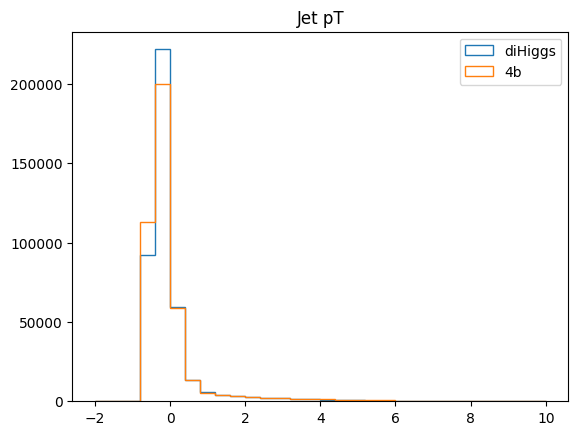

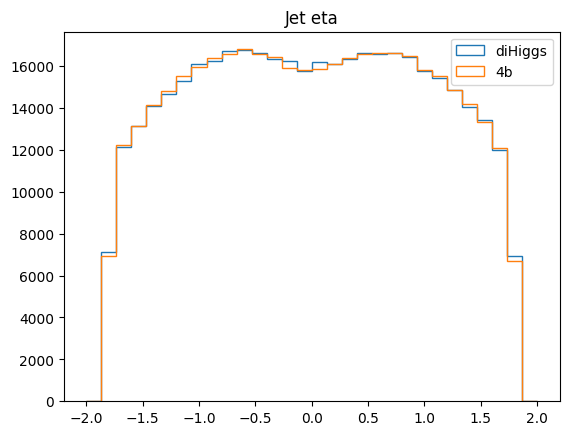

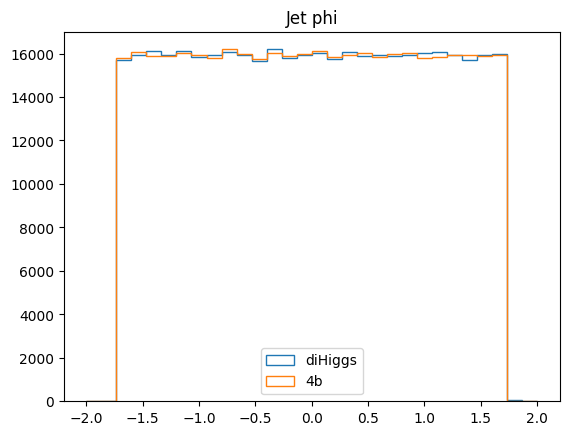

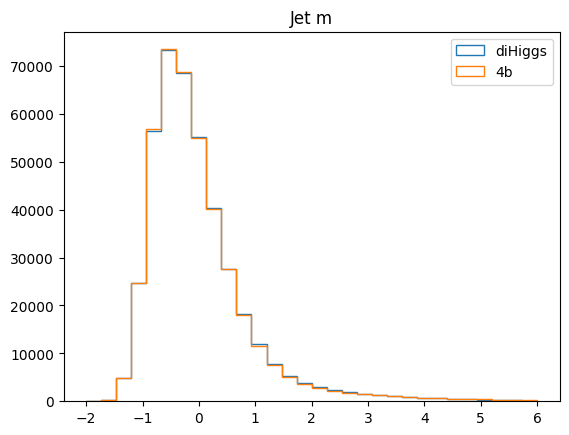

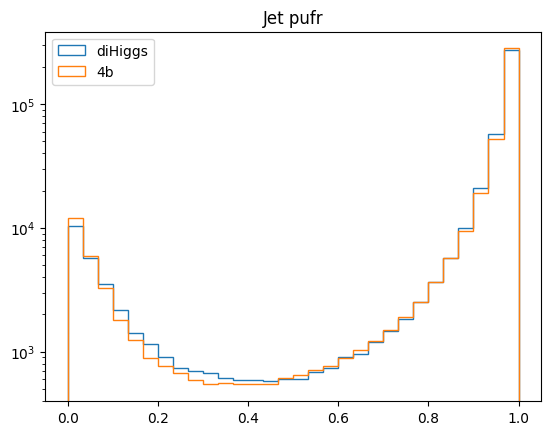

In [12]:
test = ak.Array(X_train_pufr)
sig = (np.array(y_train)==1)

plt.title("Jet pT")
plt.hist(ak.ravel(test[sig][:,:,0]),histtype='step',bins=30,label='diHiggs',range=(-2,10))
plt.hist(ak.ravel(test[~sig][:,:,0]),histtype='step',bins=30,label='4b',range=(-2,10))
plt.legend()
plt.show()
plt.title("Jet eta")
plt.hist(ak.ravel(test[sig][:,:,1]),histtype='step',bins=30,label='diHiggs',range=(-2,2))
plt.hist(ak.ravel(test[~sig][:,:,1]),histtype='step',bins=30,label='4b',range=(-2,2))
plt.legend()
plt.show()
plt.title("Jet phi")
plt.hist(ak.ravel(test[sig][:,:,2]),histtype='step',bins=30,label='diHiggs',range=(-2,2))
plt.hist(ak.ravel(test[~sig][:,:,2]),histtype='step',bins=30,label='4b',range=(-2,2))
plt.legend()
plt.show()
plt.title("Jet m")
plt.hist(ak.ravel(test[sig][:,:,3]),histtype='step',bins=30,label='diHiggs',range=(-2,6))
plt.hist(ak.ravel(test[~sig][:,:,3]),histtype='step',bins=30,label='4b',range=(-2,6))
plt.legend()
plt.show()
plt.title("Jet pufr")
plt.hist(ak.ravel(test[sig][:,:,4]),histtype='step',bins=30,label='diHiggs',range=(0,1))
plt.hist(ak.ravel(test[~sig][:,:,4]),histtype='step',bins=30,label='4b',range=(0,1))
plt.legend()
plt.yscale('log')
plt.show()

In [13]:
# Convert to torch.Tensor()
X_train_pufr = torch.nested.nested_tensor(X_train_pufr)
X_train_truth = torch.nested.nested_tensor(X_train_truth)
X_train_baseline = torch.nested.nested_tensor(X_train_baseline)
y_train = torch.Tensor(y_train).reshape(-1,1)

X_val_pufr = torch.nested.nested_tensor(X_val_pufr)
X_val_truth = torch.nested.nested_tensor(X_val_truth)
X_val_baseline = torch.nested.nested_tensor(X_val_baseline)
y_val = torch.Tensor(y_val).reshape(-1,1)

X_test_pufr = torch.nested.nested_tensor(X_test_pufr)
X_test_truth = torch.nested.nested_tensor(X_test_truth)
X_test_baseline = torch.nested.nested_tensor(X_test_baseline)
y_test = torch.Tensor(y_test).reshape(-1,1)

/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


In [18]:
class Encoder2(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder2, self).__init__()
        self.pre_norm_Q = nn.LayerNorm(embed_dim)
        self.pre_norm_K = nn.LayerNorm(embed_dim)
        self.pre_norm_V = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        #Query = self.pre_norm_Q(Query)
        #Key = self.pre_norm_K(Key)
        #Value = self.pre_norm_V(Value)
        context, weights = self.attention(Query, Key, Value)
        #context = self.post_norm(context)
        latent = Query + context
        latent = latent + F.gelu(self.out(latent))
        return latent, weights

class Model2(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Model2, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.encoder1 = Encoder2(hidden_feats,num_heads=4)
        self.encoder2 = Encoder2(hidden_feats,num_heads=4)
        self.encoder3 = Encoder2(hidden_feats,num_heads=4)
        self.jet_classifier = nn.Linear(hidden_feats,out_feats)
    def forward(self, jet_feats):
        # Preprocess Jet Feats
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))
        
        # Attention Layer + Skip Connection + Post-Process
        jet_embedding, jet_weights = self.encoder1(jet_embedding,jet_embedding,jet_embedding)
        #jet_embedding, jet_weights = self.encoder2(jet_embedding,jet_embedding,jet_embedding)
        #jet_embedding, jet_weights = self.encoder3(jet_embedding,jet_embedding,jet_embedding)
        
        # Aggregate and Classify
        jet_aggregated = jet_embedding.sum(dim=0)
        output = F.sigmoid(self.jet_classifier(jet_aggregated))
        return output

In [19]:
def train(model, optimizer, data, epochs=20):
    X_train, y_train, X_val, y_val = data
        
    history = {'train_loss':[],'test_loss':[]}
   
    for e in range(epochs):     
        cum_loss_train = []
        cum_loss_val = []
        num_train = X_train.size(0)
        model.train()
        for event in range(num_train):
            optimizer.zero_grad()
            output = model(X_train[event].to(device))
            loss = loss_fn(output, y_train[event].to(device))
            loss.backward()
            optimizer.step()
            cum_loss_train.append(loss.detach().cpu().numpy())
        
        num_val = X_val.size(0)
        model.eval()
        for event in range(num_val):
            y_pred = model(X_val[event].to(device))
            loss = loss_fn(y_pred,y_val[event].to(device))
            cum_loss_val.append(loss.detach().cpu().numpy())

        history['train_loss'].append(np.mean(cum_loss_train))
        history['test_loss'].append(np.mean(cum_loss_val))

        if (e+1)%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(np.mean(cum_loss_train)),4),'\tVal Loss:',round(float(np.mean(cum_loss_val)),4))

    return history

In [20]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


In [ ]:
# Use BinaryCrossEntropy for binary classification
loss_fn = nn.BCELoss()

Epochs = 8

# Train model with pt,eta,phi,m,pufr
print("Training with PUFR")
PUFR = Model2(5,8,1).to(device)
optimizer_pufr = optim.Adam(PUFR.parameters(), lr=0.000001)
data = [X_train_pufr, y_train, X_val_pufr, y_train]
PUFR_history = train(PUFR, optimizer_pufr, data, epochs=Epochs)
plt.plot(PUFR_history['train_loss'],label='train')
plt.plot(PUFR_history['test_loss'],label='validation')
plt.title("Pred pufr Loss")
plt.legend()
plt.show()
print()

# Train model with pt,eta,phi,m,truth
print("Training with Truth")
Truth = Model2(5,8,1).to(device)
optimizer_truth = optim.Adam(Truth.parameters(), lr=0.000001)
data = [X_train_truth, y_train, X_val_truth, y_train]
Truth_history = train(Truth, optimizer_truth, data, epochs=Epochs)
plt.plot(Truth_history['train_loss'],label='train')
plt.plot(Truth_history['test_loss'],label='validation')
plt.title("Truth pufr Loss")
plt.legend()
plt.show()
print()

# Train model with pt,eta,phi,m
print("Training Baseline")
Baseline = Model2(4,8,1).to(device)
optimizer_baseline = optim.Adam(Baseline.parameters(), lr=0.000001)
data = [X_train_baseline, y_train, X_val_baseline, y_train]
Baseline_history = train(Baseline, optimizer_baseline, data, epochs=Epochs)
plt.plot(Baseline_history['train_loss'],label='train')
plt.plot(Baseline_history['test_loss'],label='validation')
plt.title("Baseline")
plt.legend()
plt.show()
print()

Training with PUFR
Epoch: 1 	Train Loss: 2.6355 	Val Loss: 1.6075
Epoch: 2 	Train Loss: 1.1951 	Val Loss: 0.8504
Epoch: 3 	Train Loss: 0.8725 	Val Loss: 0.803
Epoch: 4 	Train Loss: 0.8413 	Val Loss: 0.786
Epoch: 5 	Train Loss: 0.8227 	Val Loss: 0.7712
Epoch: 6 	Train Loss: 0.8077 	Val Loss: 0.7589
Epoch: 7 	Train Loss: 0.7946 	Val Loss: 0.7489


In [ ]:
train_more=False
if train_more:
    Epochs = 5

    # Train model with pt,eta,phi,m,pufr
    print("Training with PUFR")
    data = [X_train_pufr, y_train, X_val_pufr, y_train]
    PUFR_history2 = train(PUFR, optimizer_pufr, data, epochs=Epochs)
    PUFR_history['train_loss'] = np.concatenate([PUFR_history['train_loss'],PUFR_history2['train_loss']], axis=0)
    PUFR_history['test_loss'] = np.concatenate([PUFR_history['test_loss'],PUFR_history2['test_loss']], axis=0)
    plt.plot(PUFR_history['train_loss'],label='train')
    plt.plot(PUFR_history['test_loss'],label='validation')
    plt.title("With pufr Loss")
    plt.legend()
    plt.show()

    # Train model with pt,eta,phi,m,pufr
    print("Training with Truth PUFR")
    data = [X_train_truth, y_train, X_val_truth, y_train]
    Truth_history2 = train(Truth, optimizer_truth, data, epochs=Epochs)
    Truth_history['train_loss'] = np.concatenate([Truth_history['train_loss'],Truth_history2['train_loss']], axis=0)
    Truth_history['test_loss'] = np.concatenate([Truth_history['test_loss'],Truth_history2['test_loss']], axis=0)
    plt.plot(Truth_history['train_loss'],label='train')
    plt.plot(Truth_history['test_loss'],label='validation')
    plt.title("With Truth pufr Loss")
    plt.legend()
    plt.show()

    print("Training Baseline")
    data = [X_train_baseline, y_train, X_val_baseline, y_train]
    Baseline_history2 = train(Baseline, optimizer_baseline, data, epochs=Epochs)
    Baseline_history['train_loss'] = np.concatenate([Baseline_history['train_loss'],Baseline_history2['train_loss']], axis=0)
    Baseline_history['test_loss'] = np.concatenate([Baseline_history['test_loss'],Baseline_history2['test_loss']], axis=0)
    plt.plot(Baseline_history['train_loss'],label='train')
    plt.plot(Baseline_history['test_loss'],label='validation')
    plt.title("Baseline")
    plt.legend()
    plt.show()

In [ ]:
def ATLAS_roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    bkg_eff = []
    
    thresholds = np.linspace(0,0.7,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(1-((y_pred[bkg] < threshold).sum() / y_true[bkg].shape[0]))

        #print("Theshold: ", threshold)
        #print("Signal Efficiency: ", sig_eff[-1])
        #print("Background Efficiency: ", bkg_eff[-1],"\n")
        
    bkg_rej = [1/x for x in bkg_eff]
    return np.array(sig_eff), np.array(bkg_rej), thresholds

def get_predictions(model, data):
    X_test, y_test = data
    model.to(device)
    model.eval()
    
    label_pred = []

    num_test = len(X_test)
    for event in range(num_test):
        l_pred = model(X_test[event].to(device))
        label_pred.append(l_pred.detach().cpu().numpy())
    label_pred = np.array(label_pred)
    return label_pred

def get_metrics(y_true, y_pred, threshold):
    y_Pred = y_pred > threshold
    x,y, thresholds = ATLAS_roc(y_true, y_pred)
    AUC = roc_auc_score(y_true, y_pred)
    BA = accuracy_score(y_true, y_Pred)
    f1 = f1_score(y_true, y_Pred)
    return x,y,thresholds,AUC,BA,f1

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]})

pufr_pred = get_predictions(PUFR, [X_test_pufr, y_test])
truth_pred = get_predictions(PUFR, [X_test_truth, y_test])
baseline_pred = get_predictions(Baseline, [X_test_baseline, y_test])

x1,y1,th1,AUC1,BA1,f11 = get_metrics(y_test, pufr_pred, 0.5)
x2,y2,th2,AUC2,BA2,f12 = get_metrics(y_test, truth_pred, 0.5)
x3,y3,th3,AUC3,BA3,f13 = get_metrics(y_test, baseline_pred, 0.5)

ax1.set_title("ATLAS ROC Curve")
ax1.set_xlabel("sig eff",loc='right')
ax1.set_ylabel("bkg rej")

ax1.plot(x1,y1, label="Pred PUFR",color='b')
AUC = "All Jets ROC AUC: " + str(round(AUC1,4))

ax1.plot(x2,y2, label="Truth PUFR",color='g')
AUC = "All Jets ROC AUC: " + str(round(AUC1,4))
#ax1.text(0.71,8,AUC)

ax1.plot(x3,y3, label="Baseline",color='r')
AUC = "Leading ROC AUC: " + str(round(AUC2,4))
#ax1.text(0.71,4,AUC)

# Plot ratio plot
x = 1-np.flip(th1)
ratio1 = np.interp(x,np.flip(x1),np.flip(y1))/np.interp(x,np.flip(x3),np.flip(y3))
ratio2 = np.interp(x,np.flip(x2),np.flip(y2))/np.interp(x,np.flip(x3),np.flip(y3))
ratio3 = np.interp(x,np.flip(x3),np.flip(y3))/np.interp(x,np.flip(x3),np.flip(y3))

ax2.plot(x,ratio1,linestyle='--',color='b')
ax2.plot(x,ratio2,linestyle='--',color='g')
ax2.plot(x,ratio3,linestyle='--',color='r')

# General Plot Settings
ax1.legend()
ax1.set_yscale('log')
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_ylim(1,10)
ax1.set_xlim(0.6,1)
ax2.set_xlim(0.6,1)
plt.show()

print("Pred PUFR\t","Binary Accuracy: ", BA1, "\tF1 Score: ", f11, "\tAUC: ", AUC1)
print("")
print("Truth PUFR\t","Binary Accuracy: ", BA2, "\tF1 Score: ", f12, "\tAUC: ", AUC2)
print("")
print("Baseline\t","Binary Accuracy: ", BA3, "\tF1 Score: ", f13, "\tAUC: ", AUC3)
print("")

In [ ]:
mask = y_test==1

plt.title("Model Score")
plt.hist(pufr_pred[mask],color='r',histtype='step',label='DiHiggs (pred pufr)',bins=30,range=(0,1))
#plt.hist(truth_pred[mask],color='k',histtype='step',label='DiHiggs (truth pufr)',bins=30,range=(0,1))
plt.hist(baseline_pred[mask],color='r',histtype='step',label='DiHiggs (wo pufr)',bins=30,range=(0,1),linestyle='--')

plt.hist(pufr_pred[~mask],color='b',histtype='step',label='4b (pred pufr)',bins=30,range=(0,1))
#plt.hist(truth_pred[~mask],color='k',histtype='step',label='4b (truth pufr)',bins=30,linestyle='--',range=(0,1))
plt.hist(baseline_pred[~mask],color='b',histtype='step',label='4b (wo pufr)',bins=30,linestyle='--',range=(0,1))
plt.legend()
plt.show()